In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import diags, kron, eye
from scipy.sparse.linalg import spsolve

# Poisson and Laplace Equation

## Steps to solve:
0. Set up residual/ L_2 norm
1. Make a Grid
2. Derive the finite difference formula

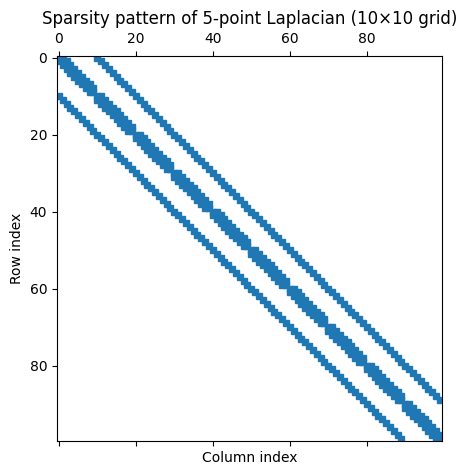

In [74]:
def build_laplacian(Nx, Ny):
    # returns CSR sparse matrix for the 5-point stencil
    data, rows, cols = [], [], []
    for j in range(Ny):
        for i in range(Nx):
            k = i + j*Nx          # flattened index
            rows += [k]; cols += [k]; data += [4.0]     # centre
            if i > 0:         rows += [k]; cols += [k-1];   data += [-1.0]
            if i < Nx-1:      rows += [k]; cols += [k+1];   data += [-1.0]
            if j > 0:         rows += [k]; cols += [k-Nx];  data += [-1.0]
            if j < Ny-1:      rows += [k]; cols += [k+Nx];  data += [-1.0]
    return sparse.csr_matrix((data, (rows, cols)), shape=(Nx*Ny, Nx*Ny))

Nx, Ny = 10, 10          # interior-grid dimensions – change as you like
A = build_laplacian(Nx, Ny)

plt.figure(figsize=(5,5))
plt.spy(A, markersize=5)
plt.title(f"Sparsity pattern of 5-point Laplacian ({Ny}×{Nx} grid)")
plt.xlabel("Column index"); plt.ylabel("Row index")
plt.show()


In [75]:
# calculates the norm
def l2_residual(u, rhs, h):
    """
    Return the L2 norm of the residual  r = A u – rhs  for the 5-point stencil.
    
    Parameters
    ----------
    u   : (Ny+2, Nx+2) array
          Current iterate, including the ghost/boundary rows and columns.
    rhs : (Ny, Nx) array  *or*  (Ny+2, Nx+2) with zeros on the boundary
          The f(x,y) term of the Poisson equation (zero for Laplace).
    h   : float
          Grid spacing (assumed uniform in x and y).
    """
    # Interior slice
    ui = u[1:-1, 1:-1]

    # Discrete Laplacian applied to u
    Au = (u[:-2, 1:-1] + u[2:, 1:-1] + u[1:-1, :-2] + u[1:-1, 2:] - 4*ui) / h**2

    # Make sure rhs has the same shape as the interior block
    rhs_i = rhs[1:-1, 1:-1] if rhs.shape == u.shape else rhs

    r = Au - rhs_i          # residual grid
    return np.linalg.norm(r.ravel(), 2)   # L2 (Euclidean) norm


def make_grid(Lx=1.0, Ly=1.0, Nx=50, Ny=50):
    hx = Lx / (Nx + 1)
    hy = Ly / (Ny + 1)
    if abs(hx - hy) > 1e-12:
        raise ValueError("5-point stencil assumes square cells ⇒ choose Nx so hx = hy.")
    x = np.linspace(0, Lx, Nx + 2)
    y = np.linspace(0, Ly, Ny + 2)
    X, Y = np.meshgrid(x, y, indexing="xy")
    u   = np.zeros((Ny + 2, Nx + 2))
    rhs = np.zeros_like(u)
    return x, y, X, Y, u, rhs, hx

## Dirichlet (fixed value)


In [76]:
def set_dirichlet(u, *, x=None, y=None,
                  left=None, right=None,
                  bottom=None, top=None):
    """
    Impose Dirichlet boundary values on the 2-D array `u` in-place.

    Parameters
    ----------
    u       : ndarray, shape (Ny+2, Nx+2)
              Solution array including the outer ghost/boundary layer.
    x, y    : 1-D arrays of length Nx+2 and Ny+2 (optional but needed for
              callable BCs).  If you built your grid with `make_grid`
              you already have these.
    left    : scalar | callable(y) | 1-D array (len Ny+2) | None
    right   : ditto
    bottom  : ditto   (bottom = south edge, y = 0)
    top     : ditto   (top = north edge, y = Ly)
    """
    Ny, Nx = u.shape[0]-2, u.shape[1]-2   # interior counts

    # Helper that writes one edge
    def _write(edge, data, idx):
        if data is None:
            return
        if np.isscalar(data):
            edge[:] = data
        elif callable(data):
            # need coordinates
            coord = y if idx in ('left', 'right') else x
            edge[:] = data(coord)
        else:                       # assume array-like
            arr = np.asarray(data)
            if arr.shape != edge.shape:
                raise ValueError(f"{idx} BC has wrong length.")
            edge[:] = arr

    # Left (x = 0)
    _write(u[:, 0], left, 'left')
    # Right (x = Lx)
    _write(u[:, -1], right, 'right')
    # Bottom (y = 0)
    _write(u[0, :], bottom, 'bottom')
    # Top (y = Ly)
    _write(u[-1, :], top, 'top')

    return u

In [77]:
# Grid with ghost cells
x, y, X, Y, u, rhs, h = make_grid(Lx=1, Ly=1, Nx=50, Ny=50)

# 1. Constant hot left wall, constant cold right wall
set_dirichlet(u, x=x, y=y,
              left=1.0,
              right=0.0)

# 2. Sinusoidal left wall, zero everywhere else
set_dirichlet(u, x=x, y=y,
              left=lambda yy: 1 + 0.3*np.sin(np.pi*yy))

# 3. Pre-computed array for the bottom edge
bottom_profile = np.exp(-10*(x-0.5)**2)
set_dirichlet(u, x=x, y=y,
              bottom=bottom_profile)

array([[0.082085  , 0.09948322, 0.11964553, ..., 0.11964553, 0.09948322,
        0.082085  ],
       [1.01846827, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.03686649, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.03686649, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.01846827, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(52, 52))

## Neumann (flux) boundaries
the normal derivative 
$$
\frac{\partial u}{\partial n} \bigg\vert_{\text{wall}} = q(x,y),
$$
fixes the (heat)flux instead of temperature. On a uniform finite-difference grid the simplest (first-order) ghost-cell update is:
$$
u_G = u_P +qh
$$
where
- $u_P$ is the interior node adjacent to the wall
- $u_G$ is the ghost value just outside the wall,
- $h$ is grid spacing
- $q$ is derivative in the outward normal direction
    - positive $q$ means flux out of domain
Need to perform this update every sweep as $u_P$ keeps changing.


In [78]:
def set_neumann(u, h, *, x=None, y=None,
                left=None, right=None,
                bottom=None, top=None):
    """
    Impose Neumann boundary conditions (first-order) on a solution array u
    that includes the ghost/boundary layer.

    Parameters
    ----------
    u       : ndarray, shape (Ny+2, Nx+2)
    h       : float   (grid spacing, assumed equal in x and y)
    x, y    : 1-D coordinate arrays (needed only if bc is callable)
    left, right, bottom, top :
        scalar | callable(coord) | 1-D array | None
        Value of ∂u/∂n (outward normal derivative).
        • Scalars give a constant flux.  
        • Callables take the 1-D coordinate along the edge.  
        • Arrays provide a node-by-node flux.  
        • None ⇒ leave that edge unchanged.
    """
    Ny, Nx = u.shape[0]-2, u.shape[1]-2  # interior counts

    def _write(edge_ghost, edge_int, bc, coord, label):
        if bc is None:
            return
        if np.isscalar(bc):
            q = bc
        elif callable(bc):
            q = bc(coord)
        else:
            q = np.asarray(bc)
            if q.shape != edge_int.shape:
                raise ValueError(f"{label} Neumann array has wrong length.")
        edge_ghost[:] = edge_int + q * h

    # West (x=0): ghost column 0, interior column 1
    _write(u[:, 0],   u[:, 1],   left,   y,   'left')
    # East (x=Lx): ghost column -1, interior column -2
    _write(u[:, -1],  u[:, -2],  right,  y,   'right')
    # South (y=0): ghost row 0, interior row 1
    _write(u[0, :],   u[1, :],   bottom, x,   'bottom')
    # North (y=Ly): ghost row -1, interior row -2
    _write(u[-1, :],  u[-2, :],  top,    x,   'top')

    return u

In [79]:
max_iter = 5
for k in range(max_iter):
    # 1️⃣ Update Dirichlet edges once (if needed)
    set_dirichlet(u, x=x, y=y,
                  left=1.0, right=0.0)

    # 2️⃣ Update Neumann edges every sweep
    #    Example: insulated top (q = 0), uniform outward flux q = 5 on bottom
    set_neumann(u, h, x=x, y=y,
                top=0.0,
                bottom=5.0)

    # 3️⃣ One relaxation sweep (Jacobi / GS / SOR)
    u = sor_sweep(u, rhs, h, w=1.8)

    # 4️⃣ Convergence check
    res = l2_residual(u, rhs, h)
    if res < tol:
        break

NameError: name 'sor_sweep' is not defined

## Mixed / Robin Boundary

- combines Dirichlet and Neumann behaviour

$$
\alpha u +\beta \frac{\partial u}{\partial n} = \gamma
$$
- $\alpha = 1, \beta = 0 \implies $ pure Dirichlet
- $\alpha = 0, \beta = 1 \implies $ pure Neumann
- Typical heat-transfer form (Newton cooling): 
$$
\beta = k, \alpha = h_c, \gamma = h_c T_\infty
$$

---
1. First-order ghost-cell formula

On our uniform grid the outward normal derivative is approximated by:
$$
\frac{\partial u}{\partial n} \approx \frac{u_G - u_P}{h}
$$
so at a wall node $P$, the robin condition becomes:
$$
\alpha u_P +\beta \frac{u_G - u_P}{h} = \gamma
$$
solving for ghost value $u_G$ :
$$
u_G = u_P +\frac{h}{\beta}\left(\gamma -\alpha u_P\right)
$$
Set this each sweep so the ghost layer tracks the evolving interior.

---


In [ ]:
def set_robin(u, h, *, x=None, y=None,
              left=None, right=None, bottom=None, top=None):
    """
    Impose first-order Robin BCs on the solution array `u`
    (shape = Ny+2 × Nx+2, incl. ghost layer).

    Each edge argument is:
        • None                → leave edge unchanged
        • (α, β, γ) scalars   → constant Robin wall
        • (α, β, γ) callables → functions of one coordinate
        • tuple of 1-D arrays → node-by-node values
    Coordinate arrays `x`, `y` are only needed when callables are used.
    """
    Ny, Nx = u.shape[0]-2, u.shape[1]-2

    def _apply(edge_G, edge_P, coeffs, coord, label):
        if coeffs is None:
            return
        α, β, γ = coeffs
        # Expand scalars / evaluate callables / validate arrays
        def _to_arr(c):
            if np.isscalar(c):
                return c
            if callable(c):
                if coord is None:
                    raise ValueError(f"{label}: callable needs coords")
                return c(coord)
            return np.asarray(c)
        α = _to_arr(α); β = _to_arr(β); γ = _to_arr(γ)
        if np.any(β == 0):
            raise ValueError(f"{label}: β cannot be zero in Robin BC")
        edge_G[:] = edge_P + h * (γ - α*edge_P) / β

    # West (x=0)
    _apply(u[:, 0],   u[:, 1],   left,   y, 'left')
    # East (x=Lx)
    _apply(u[:, -1],  u[:, -2],  right,  y, 'right')
    # South (y=0)
    _apply(u[0, :],   u[1, :],   bottom, x, 'bottom')
    # North (y=Ly)
    _apply(u[-1, :],  u[-2, :],  top,    x, 'top')

    return u

In [ ]:
# Build grid once
x, y, X, Y, u, rhs, h = make_grid(1.0, 1.0, 50, 50)

# (a) Convective cooling on the top wall, insulated elsewhere
T_inf, h_c, k = 0.0, 10.0, 1.0          # ambient, h-coef, conductivity
set_robin(u, h, x=x, y=y,
          top=(h_c, k, h_c*T_inf))      # α=h_c, β=k, γ=h_c*T_inf
set_neumann(u, h, top=None, bottom=0.0, left=0.0, right=0.0)  # optional mix

# (b) Spatially varying coefficients on the bottom edge
α_fun = lambda xx:  1 + 0.2*np.sin(2*np.pi*xx)
β_fun = lambda xx:  2.0 + 0*xx
γ_fun = lambda xx:  0.5*np.ones_like(xx)
set_robin(u, h, x=x, bottom=(α_fun, β_fun, γ_fun))


array([[0.00490196, 0.00490196, 0.00490196, ..., 0.00490196, 0.00490196,
        0.00490196],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(52, 52))

## All boundary conditions in a single function

In [ ]:
def apply_bc(u, h, bc_cfg, *, x=None, y=None):
    """
    In-place update of boundary/ghost cells for Dirichlet, Neumann, Robin.

    Parameters
    ----------
    u : ndarray (Ny+2, Nx+2)
        Current solution incl. ghost layer.
    h : float
        Uniform grid spacing.
    bc_cfg : dict
        Keys = 'left'|'right'|'bottom'|'top'.  Values = spec dicts (see table).
    x, y : 1-D coordinate arrays
        Needed when specs use callables.

    Returns
    -------
    u : same ndarray (for convenience, not a copy)
    """
    Ny, Nx = u.shape[0]-2, u.shape[1]-2

    # Edge descriptor → slice tuples (ghost, interior) + 1-D coord
    edges = {
        'left'  : (u[:, 0] , u[:, 1] , y),
        'right' : (u[:, -1], u[:, -2], y),
        'bottom': (u[0, :] , u[1, :] , x),
        'top'   : (u[-1, :], u[-2, :], x),
    }

    def _expand(spec_val, coord, label):
        """Broadcast scalar / evaluate callable / validate array shape."""
        if np.isscalar(spec_val):
            return spec_val
        if callable(spec_val):
            if coord is None:
                raise ValueError(f'{label}: callable needs coord arrays')
            return spec_val(coord)
        arr = np.asarray(spec_val)
        if arr.shape != coord.shape:
            raise ValueError(f'{label}: array length mismatch')
        return arr

    for side, spec in bc_cfg.items():
        if spec is None:
            continue
        if side not in edges:
            raise KeyError(f'Unknown edge "{side}"')

        g, p, coord = edges[side]
        bc_type = spec['type'].upper()

        if bc_type == 'D':                       # Dirichlet
            g[:] = _expand(spec['value'], coord, side)

        elif bc_type == 'N':                     # Neumann
            q = _expand(spec['flux'], coord, side)
            g[:] = p + q * h

        elif bc_type == 'R':                     # Robin
            α = _expand(spec['alpha'],  coord, side)
            β = _expand(spec['beta'],   coord, side)
            γ = _expand(spec['gamma'],  coord, side)
            if np.any(β == 0):
                raise ValueError(f'{side}: beta must be non-zero for Robin')
            g[:] = p + h * (γ - α * p) / β

        else:
            raise ValueError(f'{side}: unknown bc type "{bc_type}"')

    return u


In [ ]:
# Nx, Ny, h, x, y, X, Y already come from make_grid(...)
Nx_int, Ny_int = Nx, Ny                        # just to stress “interior”
N  = Nx_int * Ny_int                           # total unknowns

def ij_to_k(i, j):
    """(i,j) with i=0..Nx-1, j=0..Ny-1  →  flat index 0..N-1 (row-major)."""
    return i + j * Nx_int

from scipy.sparse import diags, kron, eye, csr_matrix

diag  =  2.0 * np.ones(Nx_int)
off   = -1.0 * np.ones(Nx_int-1)
T = diags([off, diag, off], offsets=[-1, 0, 1], shape=(Nx_int, Nx_int), format="csr")


I = eye(Ny_int, format="csr")
A = kron(I, T, format="csr") + kron(T, I, format="csr")
A /= h**2

# 4.1  interior sampling of f(x,y)
f_int = rhs[1:-1, 1:-1]                # shape (Ny, Nx)
b     = f_int.ravel(order="C")         # flatten row-major

# 4.2  Dirichlet walls: add g/h^2 for neighbours that touch a boundary value
gL = u[1:-1, 0]        # left wall values, length Ny
gR = u[1:-1, -1]       # right wall
gB = u[0, 1:-1]        # bottom
gT = u[-1, 1:-1]       # top

for j in range(Ny_int):
    for i in range(Nx_int):
        k = ij_to_k(i, j)
        if i == 0:       b[k] += gL[j] / h**2       # touches left wall
        if i == Nx-1:    b[k] += gR[j] / h**2
        if j == 0:       b[k] += gB[i] / h**2
        if j == Ny-1:    b[k] += gT[i] / h**2


from scipy.sparse.linalg import spsolve, cg

# Direct (sparse LU/Cholesky)—great ≤ ~1e5 unknowns
u_vec = spsolve(A, b)

# --- OR ---  Krylov (CG) with Jacobi preconditioner for larger grids
# tol = 1e-10
# u_vec, info = cg(A, b, tol=tol)
# assert info == 0, "CG did not converge"

u[1:-1, 1:-1] = u_vec.reshape((Ny_int, Nx_int), order="C")
# u now holds the full solution incl. boundaries → ready for plots

b[k] += ( -1 * u_G ) / h**2    # because A has a -1 coupling to the ghost


ValueError: matrix - rhs dimension mismatch ((100, 100) - 2500)

In [ ]:
def solve_poisson(u, rhs, h, method="jacobi", w=1.5, max_iter=50_000, tol=1e-8):
    """
    Finite-difference solver for Laplace/Poisson on a rectangular grid.
    method: 'jacobi' | 'gs' | 'sor'
    w: relaxation factor for SOR (ignored otherwise)
    """
    u = u.copy()  # don't mutate the caller's array
    for k in range(max_iter):
        if method == "jacobi":
            u_new = u.copy()
            u_new[1:-1,1:-1] = 0.25*(u[:-2,1:-1] + u[2:,1:-1] +
                                      u[1:-1,:-2] + u[1:-1,2:] -
                                      h**2 * rhs[1:-1,1:-1])
            diff = np.linalg.norm((u_new-u).ravel(), 2)
            u    = u_new

        elif method in ("gs", "sor"):
            diff = 0.0
            for j in range(1, u.shape[0]-1):
                for i in range(1, u.shape[1]-1):
                    old = u[j,i]
                    new = 0.25*(u[j-1,i] + u[j+1,i] + u[j,i-1] + u[j,i+1] -
                                h**2 * rhs[j,i])
                    if method == "sor":
                        new = old + w*(new - old)
                    diff += (new-old)**2
                    u[j,i] = new
            diff = np.sqrt(diff)
        else:
            raise ValueError("unknown method")

        if diff < tol:
            print(f"converged in {k+1} iterations (residual {diff:.2e})")
            break
    else:
        print("⚠️  reached max_iter without meeting tolerance")
    return u

u_laplace = solve_poisson(u, f, hx, method="sor", w=1.8, tol=1e-10)


IndexError: index 8 is out of bounds for axis 1 with size 8

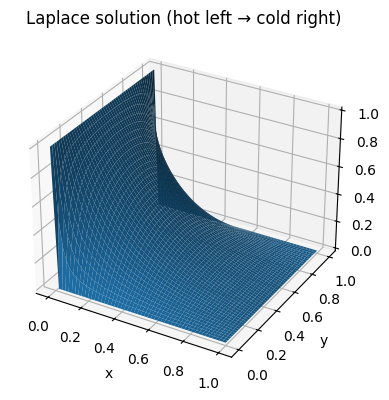

In [ ]:
fig = plt.figure(figsize=(5,4))
ax  = fig.add_subplot(111, projection="3d")
X, Y = np.meshgrid(np.linspace(0,Lx,Nx+2), np.linspace(0,Ly,Ny+2))
ax.plot_surface(X, Y, u_laplace, rstride=1, cstride=1, linewidth=0, antialiased=True)
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("u")
ax.set_title("Laplace solution (hot left → cold right)")
plt.tight_layout(); plt.show()


In [ ]:
# Gaussian source term at centre
sigma = 0.05
xc, yc = 0.5, 0.5
for j,y in enumerate(np.linspace(0,Ly,Ny+2)):
    for i,x in enumerate(np.linspace(0,Lx,Nx+2)):
        f[j,i] = np.exp(-((x-xc)**2 + (y-yc)**2) / (2*sigma**2))

# reset initial guess (zeros except BCs)
u_poiss = np.zeros_like(u)
u_poiss[:, 0]  = 1.0
u_poiss[:, -1] = 0.0

u_poiss = solve_poisson(u_poiss, f, hx, method="sor", w=1.8, tol=1e-10)


converged in 585 iterations (residual 9.99e-11)


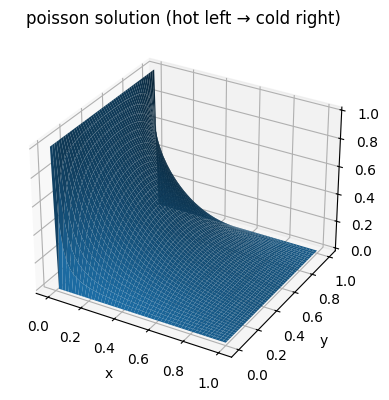

In [ ]:
fig = plt.figure(figsize=(5,4))
ax  = fig.add_subplot(111, projection="3d")
X, Y = np.meshgrid(np.linspace(0,Lx,Nx+2), np.linspace(0,Ly,Ny+2))
ax.plot_surface(X, Y, u_poiss, rstride=1, cstride=1, linewidth=0, antialiased=True)
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("u")
ax.set_title("poisson solution (hot left → cold right)")
plt.tight_layout(); plt.show()


# Examples
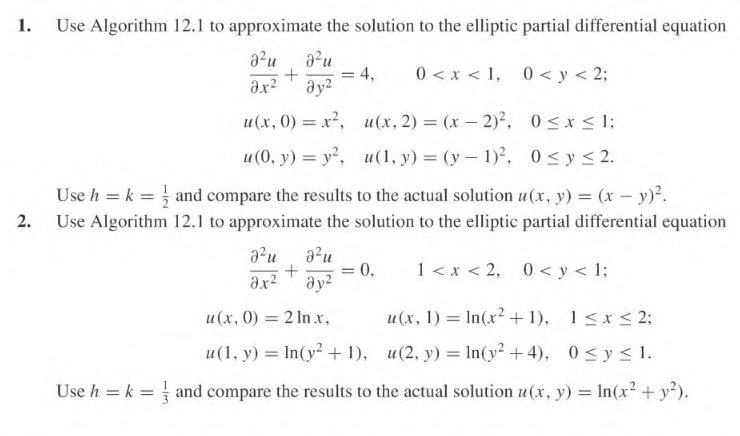

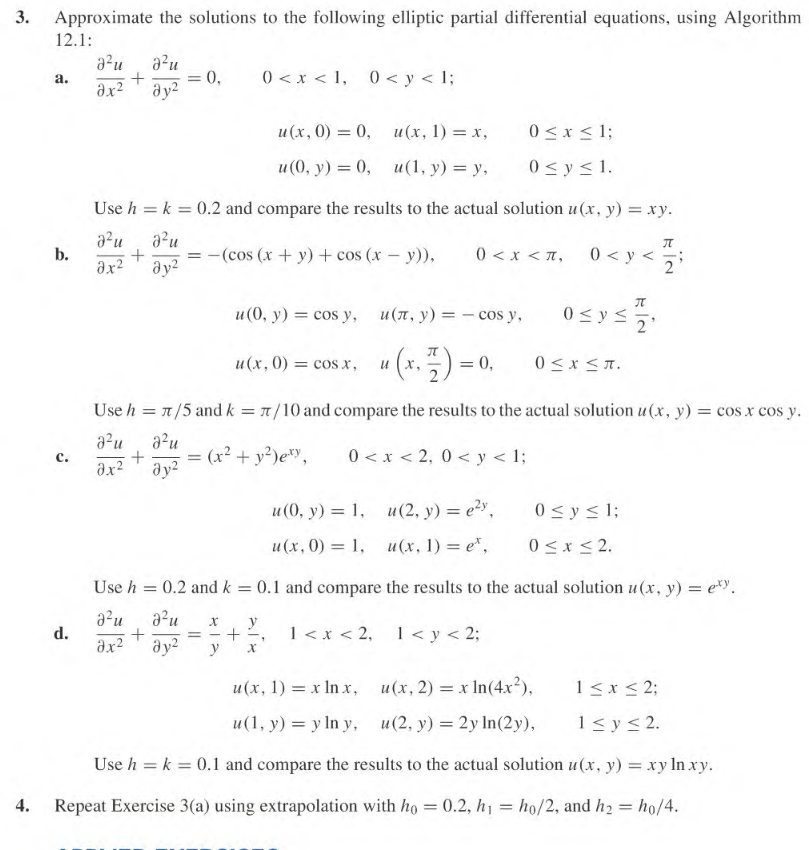

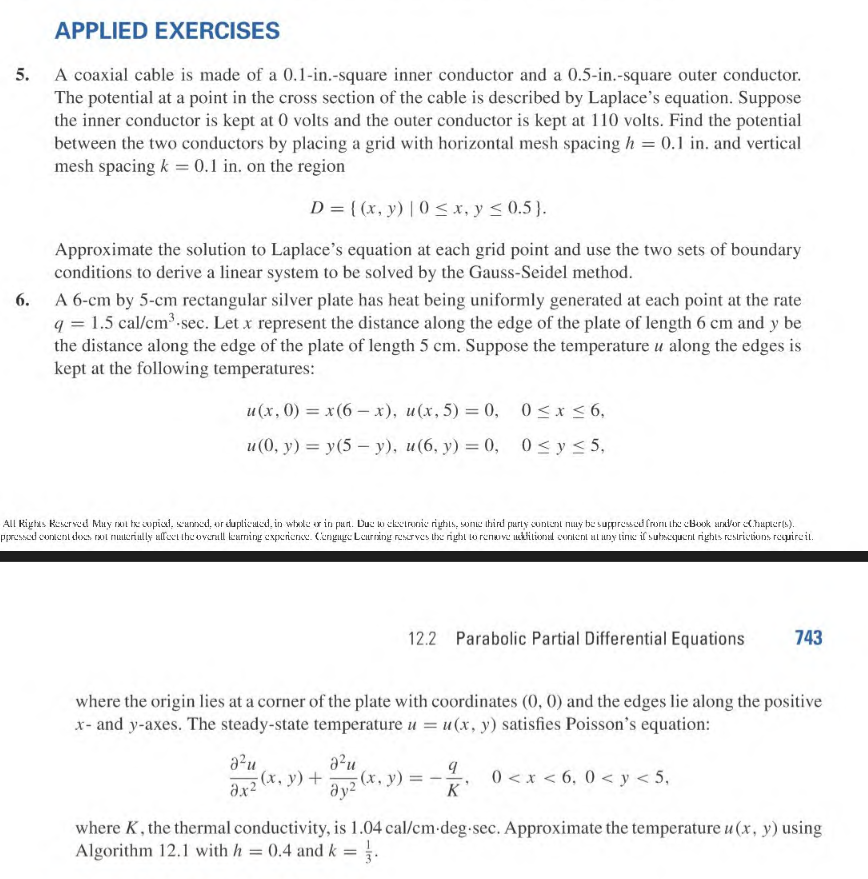

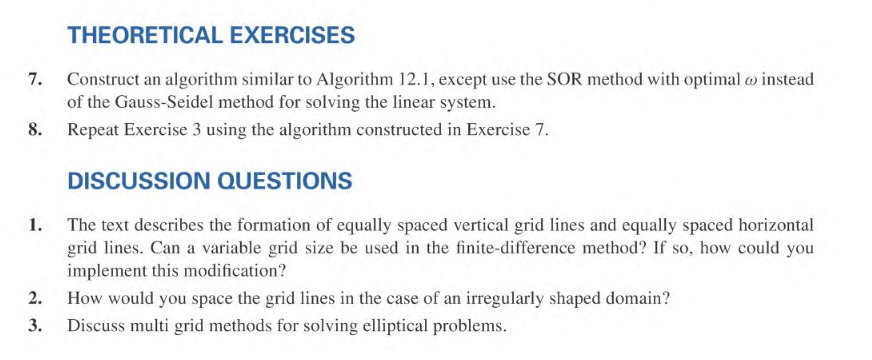

In [80]:
# 1 

# ----- 1. grid --------------------------------------------------------------
h   = 0.5
Lx, Ly = 1.0, 2.0
Nx, Ny = int(Lx/h)-1, int(Ly/h)-1        # ⇒ Nx=1, Ny=3
x = np.linspace(0, Lx, Nx+2)             # 0, 0.5, 1
y = np.linspace(0, Ly, Ny+2)             # 0 … 2 step 0.5
X, Y = np.meshgrid(x, y, indexing="xy")

u = np.zeros((Ny+2, Nx+2))               # solution incl. boundaries

# ----- 2. Dirichlet walls ---------------------------------------------------
u[:, 0]  = y**2            # left
u[:, -1] = (y-1.0)**2      # right
u[0, :]  = x**2            # bottom
u[-1, :] = (x-2.0)**2      # top

# ----- 3. assemble A and b --------------------------------------------------
diag =  2*np.ones(Nx);  off = -1*np.ones(Nx-1)
T = diags([off, diag, off], [-1,0,1], (Nx, Nx), format="csr")  # 1 × 1 here
I = eye(Ny, format="csr")
A = (kron(I, T) + kron(T, I)) / h**2        # (Ny·Nx)² = 3×3

f_int = 4*np.ones((Ny, Nx))                 # RHS  f = 4
b = f_int.ravel(order="C")

gL, gR = u[1:-1, 0],   u[1:-1, -1]
gB, gT = u[0, 1:-1],   u[-1, 1:-1]
for j in range(Ny):
    k = j*Nx         # because Nx=1 ⇒ column index i=0 only
    b[k] += (gL[j] + gR[j]) / h**2
    if j==0:   b[k] += gB[0] / h**2
    if j==Ny-1:  b[k] += gT[0] / h**2

# ----- 4. solve -------------------------------------------------------------
u_int = spsolve(A, b)                    # length 3
u[1:-1, 1:-1] = u_int.reshape((Ny, Nx))

# ----- 5. compare with exact -----------------------------------------------
u_exact = (X - Y)**2
err     = u_exact[1:-1, 1:-1] - u[1:-1, 1:-1]
print("interior numerical  :", u[1:-1, 1:-1].flatten())
print("interior exact      :", u_exact[1:-1, 1:-1].flatten())
print("interior error      :", err.flatten())
print("‖error‖₂            :", np.linalg.norm(err))

interior numerical  : [0.4375 0.5    1.4375]
interior exact      : [0.   0.25 1.  ]
interior error      : [-0.4375 -0.25   -0.4375]
‖error‖₂            : 0.667317390751957


/tmp/ipykernel_9298/3670827998.py:37: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u_int = spsolve(A, b)                    # length 3
